<a href="https://colab.research.google.com/github/lovepreetmultani/Anti-Money-Laundering/blob/main/xgboost_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports and Data load

In [ ]:
!pip install explainerdashboard

In [ ]:
!pip install torch torchvision
!pip install torch-geometric


In [ ]:
!pip install xgboost
import xgboost as xgb


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import time
from datetime import datetime as dt
from sklearn.feature_selection import  f_classif, SelectKBest
import matplotlib.pyplot as plt

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, f1_score

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
fraud=pd.read_csv("drive/My Drive/Dataset1-Big.csv")

In [ ]:
fraud.head()

,tx_fraud,tx_amount,s_pagerank,s_label,s_min_send_tx,s_min_receieve_tx,s_max_send_tx,s_max_recieve_tx,s_avg_send_tx,s_avg_recieve_tx,...,r_label,r_min_send_tx,r_min_receieve_tx,r_max_send_tx,r_max_recieve_tx,r_avg_send_tx,r_avg_recieve_tx,r_cnt_recieve_tx,r_cnt_send_tx,r_timestamp
0,False,447.72,0.58295,36700160,447.72,179.57,447.72,292119.18,447.72000,1853.61565,...,36700160,447.72,179.57,447.72,292119.18,447.72000,1853.61565,200,178,199
1,False,447.72,6.36310,36700160,15.48,5.90,296.07,5246430.50,281.01446,34892.03171,...,36700160,15.48,5.90,296.07,5246430.50,281.01446,34892.03171,945,74,199
2,False,17.37,0.37284,36700160,17.37,21.94,17.37,2099443.75,17.37000,20834.57295,...,36700160,17.37,21.94,17.37,2099443.75,17.37000,20834.57295,105,220,199
3,False,17.37,0.32571,36700160,280.45,8.12,280.45,17.37,280.45000,12.09138,...,36700160,280.45,8.12,280.45,17.37,280.45000,12.09138,58,9,199
4,False,473.85,0.28323,36700160,473.85,134.02,473.85,2530242.00,473.85000,250599.53815,...,36700160,473.85,134.02,473.85,2530242.00,473.85000,250599.53815,27,177,199


In [ ]:
fraud.columns

Index(['tx_fraud', 'tx_amount', 's_pagerank', 's_label', 's_min_send_tx',
       's_min_receieve_tx', 's_max_send_tx', 's_max_recieve_tx',
       's_avg_send_tx', 's_avg_recieve_tx', 's_cnt_recieve_tx',
       's_cnt_send_tx', 's_timestamp', 'r_pagerank', 'r_label',
       'r_min_send_tx', 'r_min_receieve_tx', 'r_max_send_tx',
       'r_max_recieve_tx', 'r_avg_send_tx', 'r_avg_recieve_tx',
       'r_cnt_recieve_tx', 'r_cnt_send_tx', 'r_timestamp'],
      dtype='object')

## Data balacing

In [ ]:
from imblearn.over_sampling import SMOTE

# ... Your existing imports and code for reading data ...

# Features and labels before SMOTE
features = fraud[['tx_amount', 's_pagerank', 's_label', 's_min_send_tx',
                 's_min_receieve_tx', 's_max_send_tx', 's_max_recieve_tx',
                 's_avg_send_tx', 's_avg_recieve_tx', 's_cnt_recieve_tx',
                 's_cnt_send_tx', 's_timestamp', 'r_pagerank', 'r_label',
                 'r_min_send_tx', 'r_min_receieve_tx', 'r_max_send_tx',
                 'r_max_recieve_tx', 'r_avg_send_tx', 'r_avg_recieve_tx',
                 'r_cnt_recieve_tx', 'r_cnt_send_tx', 'r_timestamp']]
labels = fraud['tx_fraud']

# Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
features_resampled, labels_resampled = smote.fit_resample(features, labels)

# Replace your original 'fraud' DataFrame with the resampled data
fraud_resampled = features_resampled.copy()
fraud_resampled['tx_fraud'] = labels_resampled

In [ ]:
fraud_resampled['tx_fraud'].value_counts()

False    234716
True     234716
Name: tx_fraud, dtype: int64

## Data preprocessing

In [ ]:
import torch
from torch_geometric.data import Data


# Step 1: Map unique accounts to unique integer IDs
unique_accounts = pd.concat([fraud_resampled['s_label'], fraud_resampled['r_label']]).drop_duplicates()
account_to_id = {account: i for i, account in enumerate(unique_accounts)}

# Step 2: Create the edge_index tensor
source_node_indices = fraud_resampled['s_label'].map(account_to_id).values
target_node_indices = fraud_resampled['r_label'].map(account_to_id).values

edge_index = torch.tensor(
    [
        source_node_indices,  # Source nodes
        target_node_indices   # Target nodes
    ],
    dtype=torch.long
)

<ipython-input-12-170449250967>:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  edge_index = torch.tensor(


In [ ]:
from sklearn.preprocessing import StandardScaler

# Extract the features from the resampled data
features_to_scale = ['tx_amount', 's_pagerank', 's_label', 's_min_send_tx',
                     's_min_receieve_tx', 's_max_send_tx', 's_max_recieve_tx',
                     's_avg_send_tx', 's_avg_recieve_tx', 's_cnt_recieve_tx',
                     's_cnt_send_tx', 's_timestamp', 'r_pagerank', 'r_label',
                     'r_min_send_tx', 'r_min_receieve_tx', 'r_max_send_tx',
                     'r_max_recieve_tx', 'r_avg_send_tx', 'r_avg_recieve_tx',
                     'r_cnt_recieve_tx', 'r_cnt_send_tx', 'r_timestamp']

# Initialize the scaler
scaler = StandardScaler()

# Apply scaling to the features
fraud_data_scaled = fraud_resampled.copy()
fraud_data_scaled[features_to_scale] = scaler.fit_transform(fraud_resampled[features_to_scale])


# Use the scaled features in the resampled dataset
fraud_resampled_scaled = fraud_data_scaled.copy()

# Node features for the sender and receiver
sender_features_scaled = torch.tensor(fraud_resampled_scaled[['s_pagerank', 's_label', 's_min_send_tx',
                                  's_min_receieve_tx', 's_max_send_tx', 's_max_recieve_tx',
                                  's_avg_send_tx', 's_avg_recieve_tx', 's_cnt_recieve_tx',
                                  's_cnt_send_tx', 's_timestamp']].values, dtype=torch.float)

receiver_features_scaled = torch.tensor(fraud_resampled_scaled[['r_pagerank', 'r_label', 'r_min_send_tx',
                                    'r_min_receieve_tx', 'r_max_send_tx', 'r_max_recieve_tx',
                                    'r_avg_send_tx', 'r_avg_recieve_tx', 'r_cnt_recieve_tx',
                                    'r_cnt_send_tx', 'r_timestamp']].values, dtype=torch.float)

# Combining the sender and receiver features
x_scaled = torch.cat([sender_features_scaled, receiver_features_scaled], dim=1)

# Edge features
edge_attr_scaled = torch.tensor(fraud_resampled_scaled[['tx_amount']].values, dtype=torch.float)

# Create a PyTorch Geometric data object with scaled features
data_scaled = Data(x=x_scaled, edge_index=edge_index, edge_attr=edge_attr_scaled)


## XGBoost

Test train split

In [ ]:
from sklearn.model_selection import train_test_split

# Initial train-test split
train_fraud, temp_fraud = train_test_split(fraud_resampled_scaled, test_size=0.4, random_state=42, stratify=fraud_resampled_scaled['tx_fraud'])

# Split the remaining 40% into validation and test sets
val_fraud, test_fraud = train_test_split(temp_fraud, test_size=0.5, random_state=42, stratify=temp_fraud['tx_fraud'])

In [ ]:
X_train = fraud_resampled_scaled.loc[train_fraud.index, features_to_scale]
y_train = fraud_resampled_scaled.loc[train_fraud.index, 'tx_fraud']

X_val = fraud_resampled_scaled.loc[val_fraud.index, features_to_scale]
y_val = fraud_resampled_scaled.loc[val_fraud.index, 'tx_fraud']

X_test = fraud_resampled_scaled.loc[test_fraud.index, features_to_scale]
y_test = fraud_resampled_scaled.loc[test_fraud.index, 'tx_fraud']




Train

In [ ]:
from xgboost import XGBRFClassifier
# Training the XGBoost model
''' xgb_model = XGBRFClassifier(
    nthread=-1, n_estimators=100, learning_rate=0.1,
    objective='binary:logistic', max_depth=2, scale_pos_weight=400,
    min_child_weight=80, gamma=10, max_delta_step=2
) '''

xgb_model = XGBRFClassifier(
    n_estimators=10, max_depth=3, learning_rate=0.01, objective='binary:logistic',
    booster='gbtree', gamma=0, min_child_weight=1

)


xgb_model.fit(X_train, y_train, eval_metric='error', eval_set=[(X_train, y_train), (X_val, y_val)])

# Making predictions on the test set using XGBoost
xgb_test_predictions = xgb_model.predict(X_test)

# Evaluate the XGBoost model using Precision on the test set
xgb_test_precision = precision_score(y_test, xgb_test_predictions)
print(f"XGBoost Test Precision: {xgb_test_precision}")

# Making predictions on the validation set using XGBoost
xgb_val_predictions = xgb_model.predict(X_val)

# Evaluate the XGBoost model using Precision on validation set
xgb_val_precision = precision_score(y_val, xgb_val_predictions)
print(f"XGBoost Validation Precision: {xgb_val_precision}")

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-error:0.03383	validation_1-error:0.03399
XGBoost Test Precision: 0.9693516193419612
XGBoost Validation Precision: 0.9696436238729068


Confusion Matrix:
[[45516  1428]
 [ 1778 45165]]


Classification Report:
              precision    recall  f1-score   support

       False       0.96      0.97      0.97     46944
        True       0.97      0.96      0.97     46943

    accuracy                           0.97     93887
   macro avg       0.97      0.97      0.97     93887
weighted avg       0.97      0.97      0.97     93887



Accuracy: 0.9658525674481026


Precision: 0.9693516193419612
Recall: 0.9621242783801631
f1 score: 0.965724426958604
0.9658525277381389


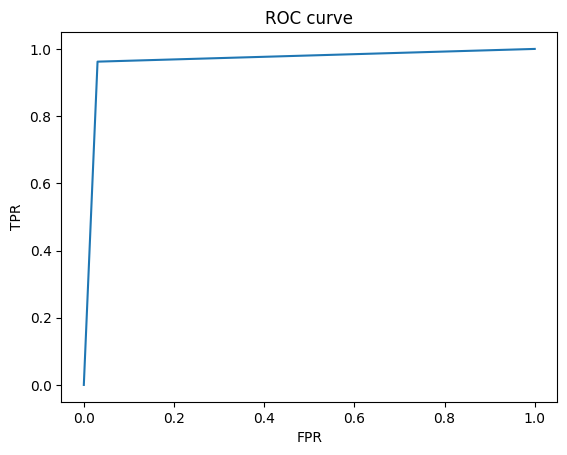

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, f1_score
result = confusion_matrix(y_test, xgb_test_predictions)
print("Confusion Matrix:")
print(result)
print('\n')
result1 = classification_report(y_test, xgb_test_predictions)
print("Classification Report:",)
print (result1)
print('\n')
x_result2 = accuracy_score(y_test,xgb_test_predictions)
print("Accuracy:",x_result2)
print('\n')
# calculate precision and recall scores
x_precision = precision_score(y_test, xgb_test_predictions)
x_recall = recall_score(y_test, xgb_test_predictions)
x_f1score = f1_score(y_test, xgb_test_predictions)

# print the results
print("Precision:", x_precision)
print("Recall:", x_recall)
print("f1 score:", x_f1score)

print(roc_auc_score(y_test, xgb_test_predictions))

fpr, tpr, _ = roc_curve(y_test, xgb_test_predictions)

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

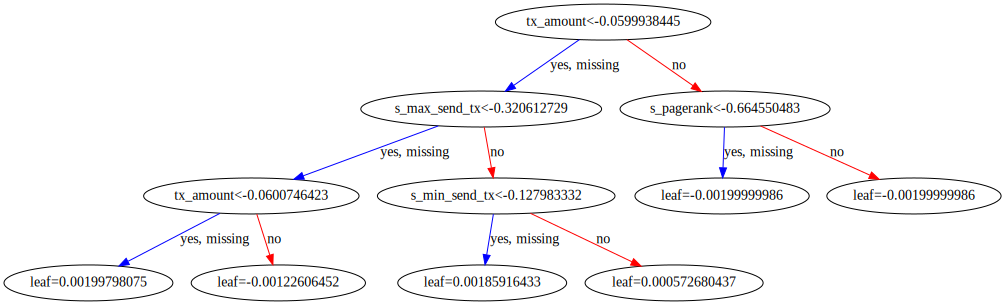

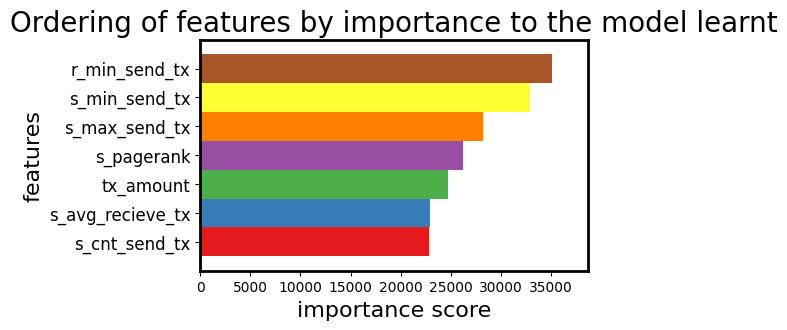

In [ ]:
from xgboost import plot_importance, to_graphviz
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(xgb_model, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)

ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of features by importance to the model learnt', size = 20);
to_graphviz(xgb_model)

In [ ]:
from explainerdashboard import ClassifierExplainer, ExplainerDashboard
explainer = ClassifierExplainer(xgb_model, X_test, y_test)
ExplainerDashboard(explainer).run()

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Training the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)

# Fitting the model on the training set
knn_model.fit(X_train, y_train)

# Making predictions on the test set using KNN
knn_test_predictions = knn_model.predict(X_test)

# Evaluate the KNN model using Precision on the test set
knn_test_precision = precision_score(y_test, knn_test_predictions)
print(f"KNN Test precision: {knn_test_precision}")

# Making predictions on the validation set using KNN
knn_val_predictions = knn_model.predict(X_val)

# Evaluate the KNN model using Precision on the validation set
knn_val_precision = precision_score(y_val, knn_val_predictions)
print(f"KNN Validation precision: {knn_val_precision}")


KNN Test precision: 0.978614325472389
KNN Validation precision: 0.9794576484137787


Confusion Matrix:
[[45922  1022]
 [  176 46767]]


Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.98      0.99     46944
        True       0.98      1.00      0.99     46943

    accuracy                           0.99     93887
   macro avg       0.99      0.99      0.99     93887
weighted avg       0.99      0.99      0.99     93887



Accuracy: 0.9872399799759285


Precision: 0.978614325472389
Recall: 0.9962507722131095
f1 score: 0.987353798083013
0.9872400759497721


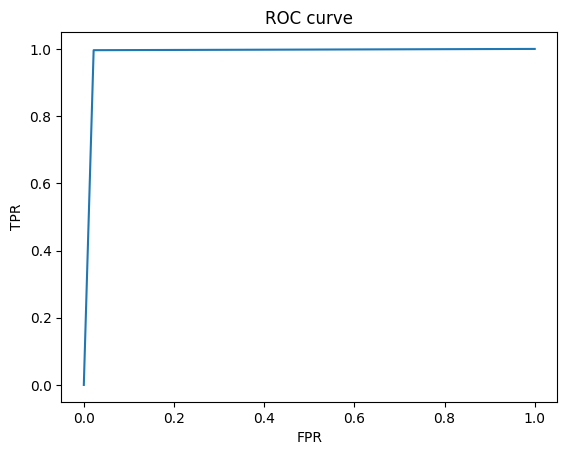

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, f1_score
result = confusion_matrix(y_test, knn_test_predictions)
print("Confusion Matrix:")
print(result)
print('\n')
result1 = classification_report(y_test, knn_test_predictions)
print("Classification Report:",)
print (result1)
print('\n')
k_result2 = accuracy_score(y_test,knn_test_predictions)
print("Accuracy:",k_result2)
print('\n')
# calculate precision and recall scores
k_precision = precision_score(y_test, knn_test_predictions)
k_recall = recall_score(y_test, knn_test_predictions)
k_f1score = f1_score(y_test, knn_test_predictions)

# print the results
print("Precision:", k_precision)
print("Recall:", k_recall)
print("f1 score:", k_f1score)

print(roc_auc_score(y_test, knn_test_predictions))

fpr, tpr, _ = roc_curve(y_test, knn_test_predictions)

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

##Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(
    criterion='entropy', max_depth=5, min_samples_split=2,
    min_samples_leaf=1, random_state=42
)

# Training the Decision Tree model
dt_model.fit(X_train, y_train)

# Making predictions on the validation set using the Decision Tree model
dt_val_predictions = dt_model.predict(X_val)

# Evaluate the Decision Tree model using Precision on the validation set
dt_val_precision = precision_score(y_val, dt_val_predictions)
print(f"Decision Tree Validation precision: {dt_val_precision}")

# Making predictions on the test set using the Decision Tree model
dt_test_predictions = dt_model.predict(X_test)

# Evaluate the Decision Tree model using Precision on the test set
dt_test_precision = precision_score(y_test, dt_test_predictions)
print(f"Decision Tree Test precision: {dt_test_precision}")


Decision Tree Validation precision: 0.9554851927733283
Decision Tree Test precision: 0.955251349283484


Confusion Matrix:
[[44780  2164]
 [  748 46195]]


Classification Report:
              precision    recall  f1-score   support

       False       0.98      0.95      0.97     46944
        True       0.96      0.98      0.97     46943

    accuracy                           0.97     93887
   macro avg       0.97      0.97      0.97     93887
weighted avg       0.97      0.97      0.97     93887



Accuracy: 0.9689839913939097


Precision: 0.955251349283484
Recall: 0.9840657819057155
f1 score: 0.9694445027386623
0.9689841520298856


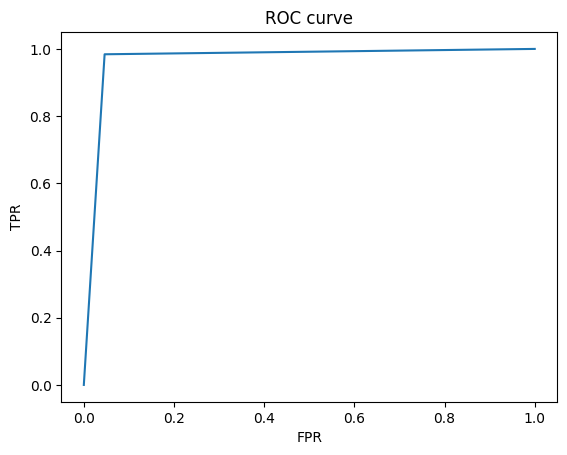

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, f1_score
result = confusion_matrix(y_test, dt_test_predictions)
print("Confusion Matrix:")
print(result)
print('\n')
result1 = classification_report(y_test, dt_test_predictions)
print("Classification Report:",)
print (result1)
print('\n')
d_result2 = accuracy_score(y_test,dt_test_predictions)
print("Accuracy:",d_result2)
print('\n')
# calculate precision and recall scores
d_precision = precision_score(y_test, dt_test_predictions)
d_recall = recall_score(y_test, dt_test_predictions)
d_f1score = f1_score(y_test, dt_test_predictions)

# print the results
print("Precision:", d_precision)
print("Recall:", d_recall)
print("f1 score:", d_f1score)

print(roc_auc_score(y_test, dt_test_predictions))

fpr, tpr, _ = roc_curve(y_test, dt_test_predictions)

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

## GNN


Model building

In [ ]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [ ]:
class GNNModel(torch.nn.Module):
    def __init__(self, num_node_features):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(num_node_features, 32)  # Increased from 16 to 32
        self.conv2 = GCNConv(32, 16)  # New layer
        self.conv3 = GCNConv(16, 2)  # Output layer

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)  # New layer
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)


Test train split

In [ ]:
from sklearn.model_selection import train_test_split

# Initial train-test split
train_fraud, temp_fraud = train_test_split(fraud_resampled_scaled, test_size=0.4, random_state=42, stratify=fraud_resampled_scaled['tx_fraud'])

# Split the remaining 40% into validation and test sets
val_fraud, test_fraud = train_test_split(temp_fraud, test_size=0.5, random_state=42, stratify=temp_fraud['tx_fraud'])

# Initialize masks
train_mask = torch.zeros(len(fraud_resampled_scaled), dtype=torch.bool)
val_mask = torch.zeros(len(fraud_resampled_scaled), dtype=torch.bool)
test_mask = torch.zeros(len(fraud_resampled_scaled), dtype=torch.bool)

# Update masks based on the indices of the train, validation and test sets
train_mask[train_fraud.index] = True
val_mask[val_fraud.index] = True
test_mask[test_fraud.index] = True

# Update your data object
data_scaled.train_mask = train_mask
data_scaled.val_mask = val_mask
data_scaled.test_mask = test_mask
data_scaled.y = torch.tensor(fraud_resampled_scaled['tx_fraud'].values, dtype=torch.long)

Training

In [ ]:
# Number of node features
num_node_features = x_scaled.shape[1]

In [ ]:
# Initialize the model and optimizer
GN_model = GNNModel(data_scaled.num_node_features)
optimizer = torch.optim.Adam(GN_model.parameters(), lr=0.01)

# Lists to hold loss and precision values for plotting or analysis
train_losses = []
val_losses = []
train_precisions = []
val_precisions = []

# Training loop with validation
for epoch in range(200):
    GN_model.train()
    optimizer.zero_grad()
    out = GN_model(data_scaled)

    # Training loss
    train_loss = F.nll_loss(out[data_scaled.train_mask], data_scaled.y[data_scaled.train_mask])
    train_loss.backward()
    optimizer.step()

    # Calculate training precision
    _, train_pred = out[data_scaled.train_mask].max(dim=1)
    train_true = data_scaled.y[data_scaled.train_mask]
    train_precision = precision_score(train_true.cpu(), train_pred.cpu(), average='micro')

    # Validation
    GN_model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Deactivate autograd engine to reduce memory usage and speed up computations
        val_loss = F.nll_loss(out[data_scaled.val_mask], data_scaled.y[data_scaled.val_mask])

        # Calculate validation precision
        _, val_pred = out[data_scaled.val_mask].max(dim=1)
        val_true = data_scaled.y[data_scaled.val_mask]
        val_precision = precision_score(val_true.cpu(), val_pred.cpu(), average='micro')

    # Print the metrics
    print(f"Epoch {epoch+1}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}, Training Precision: {train_precision}, Validation Precision: {val_precision}")

Epoch 1, Training Loss: 0.8507736921310425, Validation Loss: 0.8540202975273132, Training Precision: 0.5123642418669384, Validation Precision: 0.5128134120103104
Epoch 2, Training Loss: 0.7528509497642517, Validation Loss: 0.75123530626297, Training Precision: 0.535544754472607, Validation Precision: 0.5374177193617792
Epoch 3, Training Loss: 0.7140596508979797, Validation Loss: 0.7127236723899841, Training Precision: 0.546590025527322, Validation Precision: 0.5475257226849584
Epoch 4, Training Loss: 0.694470226764679, Validation Loss: 0.6937756538391113, Training Precision: 0.5579086768042207, Validation Precision: 0.5598065739300854
Epoch 5, Training Loss: 0.6794331073760986, Validation Loss: 0.6794774532318115, Training Precision: 0.5728416276419358, Validation Precision: 0.5724708689261445
Epoch 6, Training Loss: 0.6655293703079224, Validation Loss: 0.6662406921386719, Training Precision: 0.5902705044042619, Validation Precision: 0.5885222503887694
Epoch 7, Training Loss: 0.6542511

In [ ]:
# Testing and Evaluation
GN_model.eval()
_, pred = out.max(dim=1)
correct = float(pred[data_scaled.test_mask].eq(data_scaled.y[data_scaled.test_mask]).sum().item())
acc = correct / data_scaled.test_mask.sum().item()
print(f"Test Accuracy: {acc}")

from sklearn.metrics import precision_score


# Testing and Evaluation
GN_model.eval()
_, pred = out.max(dim=1)

# Extract ground truth and predictions for test set
true_labels = data_scaled.y[data_scaled.test_mask].cpu().numpy()
predicted_labels = pred[data_scaled.test_mask].cpu().numpy()

Test Accuracy: 0.8752649461586801


Confusion Matrix:
[[36784 10160]
 [ 1551 45392]]


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.78      0.86     46944
           1       0.82      0.97      0.89     46943

    accuracy                           0.88     93887
   macro avg       0.89      0.88      0.87     93887
weighted avg       0.89      0.88      0.87     93887



Accuracy: 0.8752649461586801


Precision: 0.8171082949308756
Recall: 0.9669599301280276
f1 score: 0.8857407678423338
0.8752659228008917


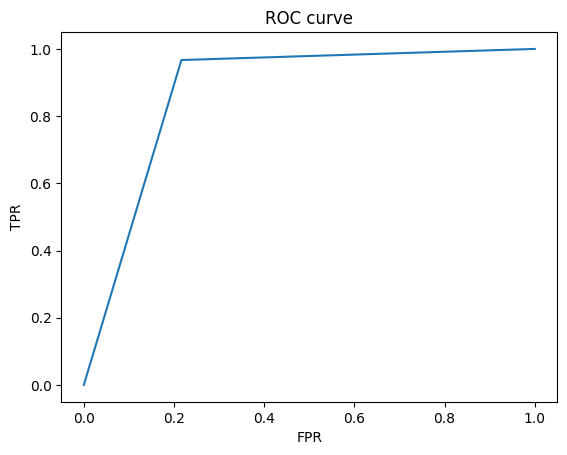

In [ ]:
from sklearn.metrics import f1_score
result = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(result)
print('\n')
result1 = classification_report(true_labels, predicted_labels)
print("Classification Report:",)
print (result1)
print('\n')
g_result2 = accuracy_score(true_labels,predicted_labels)
print("Accuracy:",g_result2)
print('\n')
# calculate precision and recall scores
g_precision = precision_score(true_labels, predicted_labels)
g_recall = recall_score(true_labels, predicted_labels)
g_f1score = f1_score(true_labels, predicted_labels)

# print the results
print("Precision:", g_precision)
print("Recall:", g_recall)
print("f1 score:", g_f1score)

print(roc_auc_score(true_labels, predicted_labels))

fpr, tpr, _ = roc_curve(true_labels, predicted_labels)

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

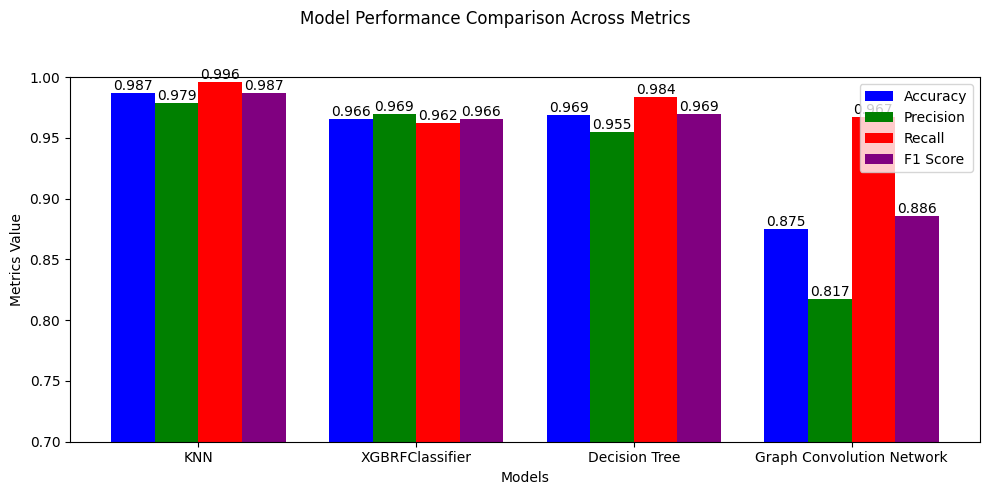

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the models and their performance metrics
models = ['KNN', 'XGBRFClassifier', 'Decision Tree', 'Graph Convolution Network']
accuracy = [k_result2, x_result2, d_result2, g_result2]
precision = [k_precision, x_precision, d_precision, g_precision]
recall = [k_recall, x_recall, d_recall, g_recall]
f1_score = [k_f1score, x_f1score, d_f1score, g_f1score]

# Create a single plot for all metrics using grouped bar chart
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Model Performance Comparison Across Metrics')

# Set the positions and width for the bars
pos = np.arange(len(models))
bar_width = 0.2

# Plot bars for each metric
rects1 = ax.bar(pos - bar_width*1.5, accuracy, bar_width, label='Accuracy', color='blue')
rects2 = ax.bar(pos - bar_width/2, precision, bar_width, label='Precision', color='green')
rects3 = ax.bar(pos + bar_width/2, recall, bar_width, label='Recall', color='red')
rects4 = ax.bar(pos + bar_width*1.5, f1_score, bar_width, label='F1 Score', color='purple')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Models')
ax.set_ylabel('Metrics Value')
ax.set_xticks(pos)
ax.set_xticklabels(models)
ax.set_ylim([0.7, 1.0])
ax.legend()

# Label with specially formatted floats
ax.bar_label(rects1, fmt='%.3f')
ax.bar_label(rects2, fmt='%.3f')
ax.bar_label(rects3, fmt='%.3f')
ax.bar_label(rects4, fmt='%.3f')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## MPNN

In [ ]:
from torch_geometric.nn import MessagePassing

In [ ]:
class MPNNLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(MPNNLayer, self).__init__(aggr='mean')  # "Mean" aggregation.
        self.lin = torch.nn.Linear(in_channels, out_channels)
        self.act = torch.nn.ReLU()

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x)

    def message(self, x_j, edge_index, size):
        # x_j has shape [E, in_channels]
        x_j = self.lin(x_j)
        x_j = self.act(x_j)
        return x_j

    def update(self, aggr_out):
        # aggr_out has shape [N, out_channels]
        return aggr_out

In [ ]:
class MPNNModel(torch.nn.Module):
    def __init__(self, num_node_features):
        super(MPNNModel, self).__init__()
        self.layer1 = MPNNLayer(num_node_features, 64)  # Increase to 64 nodes
        self.layer2 = MPNNLayer(64, 32)  # New layer
        self.layer3 = MPNNLayer(32, 32)  # New layer
        self.layer4 = MPNNLayer(32, 16)  # Reduce to 16 nodes
        self.layer5 = MPNNLayer(16, 2)   # Output layer for binary classification

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.layer1(x, edge_index))
        x = F.relu(self.layer2(x, edge_index))
        x = F.relu(self.layer3(x, edge_index))
        x = F.relu(self.layer4(x, edge_index))
        x = self.layer5(x, edge_index)
        return F.log_softmax(x, dim=1)


In [ ]:
# Initialize the model and optimizer
MPNN_model = MPNNModel(data_scaled.num_node_features)
optimizer = torch.optim.Adam(MPNN_model.parameters(), lr=0.001)
# Initialize the SGD optimizer with momentum

# Lists to hold loss and precision values for plotting or analysis
train_losses = []
val_losses = []
train_precisions = []
val_precisions = []

# Training loop with validation
for epoch in range(200):
    MPNN_model.train()
    optimizer.zero_grad()
    out = MPNN_model(data_scaled)

    # Training loss
    train_loss = F.nll_loss(out[data_scaled.train_mask], data_scaled.y[data_scaled.train_mask])
    train_loss.backward()
    optimizer.step()

    # Calculate training precision
    _, train_pred = out[data_scaled.train_mask].max(dim=1)
    train_true = data_scaled.y[data_scaled.train_mask]
    train_precision = precision_score(train_true.cpu(), train_pred.cpu(), average='micro')

    # Validation
    MPNN_model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Deactivate autograd engine to reduce memory usage and speed up computations
        val_loss = F.nll_loss(out[data_scaled.val_mask], data_scaled.y[data_scaled.val_mask])

        # Calculate validation precision
        _, val_pred = out[data_scaled.val_mask].max(dim=1)
        val_true = data_scaled.y[data_scaled.val_mask]
        val_precision = precision_score(val_true.cpu(), val_pred.cpu(), average='micro')

    # Print the metrics
    print(f"Epoch {epoch+1}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}, Training Precision: {train_precision}, Validation Precision: {val_precision}")

Epoch 1, Training Loss: 0.6929028034210205, Validation Loss: 0.6929224133491516, Training Precision: 0.49999822480375206, Validation Precision: 0.5
Epoch 2, Training Loss: 0.6928874850273132, Validation Loss: 0.6929083466529846, Training Precision: 0.49999822480375206, Validation Precision: 0.5
Epoch 3, Training Loss: 0.6928715109825134, Validation Loss: 0.6928941011428833, Training Precision: 0.49999822480375206, Validation Precision: 0.5
Epoch 4, Training Loss: 0.6928553581237793, Validation Loss: 0.6928796768188477, Training Precision: 0.49999822480375206, Validation Precision: 0.5
Epoch 5, Training Loss: 0.6928388476371765, Validation Loss: 0.6928649544715881, Training Precision: 0.49999822480375206, Validation Precision: 0.5
Epoch 6, Training Loss: 0.6928218007087708, Validation Loss: 0.6928497552871704, Training Precision: 0.49999822480375206, Validation Precision: 0.5
Epoch 7, Training Loss: 0.6928039789199829, Validation Loss: 0.6928339004516602, Training Precision: 0.499998224